# Phenolopy Metrics module tests

## Globals

In [1]:
# set globals paths
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
TEST_MODULE = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\tests\code'
GRP_LYR_FILE = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx'    

## Setup

### Imports

In [2]:
# imports
import os
import random
import numpy as np
import xarray as xr
from IPython.utils import io

# import testing functions
sys.path.append(TEST_MODULE)
import test_funcs

# import full arcpy toolbox
arcpy.ImportToolbox(r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\toolbox\tenement-tools-toolbox.pyt")

<module 'toolbox'>

### Reload libraries

In [3]:
# if scripts change, reload
from importlib import reload
reload(test_funcs)

<module 'test_funcs' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\tests\\code\\test_funcs.py'>

### Set data files and locations

In [4]:
# setup general io. nc ins and outs exist in these folders
input_folder = r'E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs'
output_folder = r'E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\outputs'

# temp nc file for use when breaking ncs
temp_nc = os.path.join(input_folder, 'temp_nc.nc')  

# setup landsat cubes paths
ls_cubes = [
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\yandi_1_ls_90_20_raw_odc.nc",
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\yandi_2_ls_90_20_raw_odc.nc", 
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\yandi_3_ls_90_20_raw_odc.nc",
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\yandi_4_ls_90_20_raw_odc.nc", 
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\dwer_1_ls_90_20_raw_odc.nc",  
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\roy_1_ls_10_20_raw_odc.nc",
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\roy_3_ls_10_20_raw_odc.nc",
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\tute_1_ls_10_20_raw_odc.nc",  
]

# setup sentinel2 cubes paths
s2_cubes = [
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\yandi_2_s2_16_20_raw_odc.nc", 
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\yandi_3_s2_16_20_raw_odc.nc",
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\yandi_4_s2_16_20_raw_odc.nc",
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\dwer_1_s2_16_20_raw_odc.nc",  
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\roy_2_s2_16_21_raw_odc.nc",   
    r"E:\Curtin\GDVII - General\Work Package 2\test_data\gdvspectra_likelihood\inputs\tute_1_s2_18_20_raw_odc.nc",
]

### Set specific raw netcdf file

In [5]:
# set specific dataset
nc_file = ls_cubes[1]
#nc_file = s2_cubes[4]

### Set up function to iterate corruptor and tests

In [6]:
def run_corruptors_through_tests(in_nc, nc_coors, tests, verbose):
    """
    this func takes a path to nc file or raw sat imagery, a list of nc
    corruptor funcs and params, a list of test funcs and params. Each 
    nc corruptor func is iterated through, and for each corrupted nc, 
    each test in tests is applied to corrupted nc. verbose sets how
    much information is printed.
    """
    
    for nc_corr in nc_corrs:
        corr_name = nc_corr[0].__name__                   # name of current corruptor func
        corr_func, corr_params = nc_corr[0], nc_corr[1]   # pointer to corruptor func and dict of params
        
        # notify
        print('Corrupting NetCDF via: {}.\n'.format(corr_name) + '- ' * 30)

        # create temp nc and corrupt it with current corruptor
        if not verbose:
            with io.capture_output() as cap:
                test_funcs.create_temp_nc(in_nc=in_nc, out_nc=temp_nc)
        else:
            test_funcs.create_temp_nc(in_nc=in_nc, out_nc=temp_nc)

        # run current corruptor function
        try:
            corr_func(**corr_params)
        except Exception as e:    
            print(e)
            print('Corruptor did not have enough data to work with. Skipping.\n')

        # iter each test func and apply to current corrupt nc
        for test in tests:
            test_nc_name = corr_name + '_' + test[0]    # name of current test nc
            test_func, test_params = test[1], test[2]   # pointer to test func and dict of params
            test_msg = test[3]
            
            # notify of test message
            print(test_msg)

            # create output nc file path and name and update params for in/out paths
            out_nc_file = os.path.join(output_folder, test_nc_name)
            
            # remove output nc if exists
            if os.path.exists(out_nc_file):
                os.remove(out_nc_file)
            
            # update params
            test_params.update({'in_nc_file': temp_nc, 'out_metrics_nc_path': out_nc_file})

            # perform current test
            try:
                # notify
                print('Performing test: {}.'.format(test_nc_name))

                # perform test, provide prints if requested
                if not verbose:
                    with io.capture_output() as cap:
                        test_func(**test_params)
                else:
                    test_func(**test_params)
                    print('\n')

            except Exception as e:    
                print(e)

        # notify
        print('All tests applied to corruptor NetCDF.\n\n')

### Set up netcdf corruptor functions

In [ ]:
# these are numerous netcdf corruptors. feed a raw nc in, break it, output as temp nc
# comment out any that are irrelevant
# each of these uncommented will be fed through the tests below
def build_nc_corruptors(temp_nc):
    """
    each one of these is a unique netcdf corruptor functions and 
    associated parameters. 
    """
    
    # set up list
    cs = []

    # func: raw default dataset, no changes
    cs.append([test_funcs.nc_default, {'in_nc': temp_nc}])

    # func: remove x, y, time, spatial_ref coords
    #cs.append([test_funcs.remove_coord, {'in_nc': temp_nc, 'coord': 'x'}])
    #cs.append([test_funcs.remove_coord, {'in_nc': temp_nc, 'coord': 'y'}])
    #cs.append([test_funcs.remove_coord, {'in_nc': temp_nc, 'coord': 'time'}])
    #cs.append([test_funcs.remove_coord, {'in_nc': temp_nc, 'coord': 'spatial_ref'}])

    #func: remove red and oa_fmask band vars
    #cs.append([test_funcs.remove_var, {'in_nc': temp_nc, 'var': 'nbart_red'}])
    #cs.append([test_funcs.remove_var, {'in_nc': temp_nc, 'var': 'oa_fmask'}])

    #func: limit number of years in various combos
    #cs.append([test_funcs.limit_years, {'in_nc': temp_nc, 's_year': 1990, 'e_year': 1990}])
    #cs.append([test_funcs.limit_years, {'in_nc': temp_nc, 's_year': 2010, 'e_year': 2010}])
    #cs.append([test_funcs.limit_years, {'in_nc': temp_nc, 's_year': 2012, 'e_year': 2012}])
    #cs.append([test_funcs.limit_years, {'in_nc': temp_nc, 's_year': 1991, 'e_year': 1992}])
    #cs.append([test_funcs.limit_years, {'in_nc': temp_nc, 's_year': 2005, 'e_year': 2006}])
    #cs.append([test_funcs.limit_years, {'in_nc': temp_nc, 's_year': 2019, 'e_year': 2020}])
    #cs.append([test_funcs.limit_years, {'in_nc': temp_nc, 's_year': 1993, 'e_year': 1995}])
    #cs.append([test_funcs.limit_years, {'in_nc': temp_nc, 's_year': 2010, 'e_year': 2012}])
    #cs.append([test_funcs.limit_years, {'in_nc': temp_nc, 's_year': 2011, 'e_year': 2013}])

    #func: set all vars to nan
    #cs.append([test_funcs.set_nc_vars_all_nan, {'in_nc': temp_nc}])

    #func: set all vars to zero
    #cs.append([test_funcs.set_nc_vars_all_zero, {'in_nc': temp_nc}])

    #func: set all vars for 10 rand times to all nan
    #cs.append([test_funcs.set_nc_vars_random_all_nan, {'in_nc': temp_nc, 'num': 10}])

    #func: strip all attrs from nc    
    #cs.append([test_funcs.strip_nc_attributes, {'in_nc': temp_nc}])

    #func: set vars in first and last time index to all nan
    #cs.append([test_funcs.set_end_times_to_all_nan, {'in_nc': temp_nc}])

    #func: reduce whole nc to one random time slice
    #cs.append([test_funcs.reduce_to_one_scene, {'in_nc': temp_nc}])

    #func: set wet months all nan, all years, for specific months
    #cs.append([test_funcs.set_all_specific_season_nan, {'in_nc': temp_nc, 'months': [1]}])
    #cs.append([test_funcs.set_all_specific_season_nan, {'in_nc': temp_nc, 'months': [1, 2, 3]}])
    #cs.append([test_funcs.set_all_specific_season_nan, {'in_nc': temp_nc, 'months': [7, 8, 9, 10, 11, 12]}])

    #func: set wet months all nan, specific years, for specific months
    #cs.append([test_funcs.set_specific_years_season_nan, {'in_nc': temp_nc, 'years': [1990], 'months': [1, 2, 3]}])
    #cs.append([test_funcs.set_specific_years_season_nan, {'in_nc': temp_nc, 'years': [2005], 'months': [1, 2, 3]}])
    #cs.append([test_funcs.set_specific_years_season_nan, {'in_nc': temp_nc, 'years': [2006, 2007], 'months': [1, 2, 3]}])

    #func: drop wet months, all years, for specific months
    #cs.append([test_funcs.remove_all_specific_season_nan, {'in_nc': temp_nc, 'months': [1]}])
    #cs.append([test_funcs.remove_all_specific_season_nan, {'in_nc': temp_nc, 'months': [1, 2, 3]}])
    #cs.append([test_funcs.remove_all_specific_season_nan, {'in_nc': temp_nc, 'months': [7, 8, 9, 10, 11, 12]}])

    #func: drop wet months, specific years, for specific months (note: seperate tests)
    #cs.append([test_funcs.remove_specific_years_season_nan, {'in_nc': temp_nc, 'years': [1990], 'months': [1, 2, 3]}])
    #cs.append([test_funcs.remove_specific_years_season_nan, {'in_nc': temp_nc, 'years': [2009], 'months': [1, 2, 3]}])
    #cs.append([test_funcs.remove_specific_years_season_nan, {'in_nc': temp_nc, 'years': [2007, 2008], 'months': [1, 2, 3]}])

    #func: remove crs attribute
    #cs.append([test_funcs.remove_crs_attr, {'in_nc': temp_nc}])

    #func: invalidate crs attribute
    #cs.append([test_funcs.invalidate_crs_attr, {'in_nc': temp_nc, 'crs_text': 'EPSG:4326'}])
    #cs.append([test_funcs.invalidate_crs_attr, {'in_nc': temp_nc, 'crs_text': ''}])

    #func: remove nodatavals attribute
    #cs.append([test_funcs.remove_nodatavals_attr, {'in_nc': temp_nc}])
    
    return cs

nc_corruptors = build_nc_corruptors(temp_nc=temp_nc)

## Run tests

### Test One: Use all dates

In [ ]:
def build_test_one_funcs(in_nc, temp_nc):
    """sets up test one functions"""
    
    # set default params for tool
    inputs = {
        'in_nc': '',                              # input nc (i.e. temp nc)
        'out_nc': '',                             # output nc (i.e. t1a nc)
        'in_use_all_dates': True,                 # use all dates
        'in_specific_years': '2019;2020',         # specif year(s)
        'in_metrics': None,                       # metrics list
        'in_veg_idx': 'MAVI',                     # veg index name       
        'in_method_type': 'Seasonal amplitude',   # season method
        'in_amp_factor': 0.75,                    # amplitude factor
        'in_abs_value': 0.3,                      # absolute value
        'in_sav_window_length': 3,                # savitsky window size
        'in_sav_polyorder': 1,                    # savitsky poly order
        'in_out_window_length': 3,                # outlier window length
        'in_out_factor': 2,                       # outlier user factor
        'in_fix_edges': True,                     # fix doy edges
        'in_fill_nans': True,                     # fill empty pixels
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
    
    msg = 'Running Test One: default in use all dates.'
    params = inputs.copy()
    params.update({'in_add_result_to_map': True})
    ts.append(['t_1_def.nc', arcpy.Phenolopy_Metrics_toolbox , params, msg])
    
    msg = 'Running Test One: use all dates is false.'
    params = inputs.copy()
    params.update({'in_add_result_to_map': False})
    ts.append(['t_1_a.nc', arcpy.Phenolopy_Metrics_toolbox , params, msg])    

    msg = 'Running Test One: use all dates is None (default to True).'
    params = inputs.copy()
    params.update({'in_add_result_to_map': None})
    ts.append(['t_1_b.nc', arcpy.Phenolopy_Metrics_toolbox , params, msg])   
            
    return ts

### Test One: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_one_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Two: Dry Months

In [ ]:
def build_test_two_funcs(in_nc, temp_nc):
    """sets up test two functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                      # wet months 
        'in_dry_months': '',                      # dry months 
        'in_veg_idx': 'MAVI',                     # vege index name
        'in_mst_idx': 'NDMI',                     # moisture index name       
        'in_aggregate': False,                    # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': 0.99,                  # upper quantile for standardisation
        'in_stand_qlower': 0.05,                  # lower quantile for standardisation
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_interpolate': True,                   # interpolate missing pixels
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default dry months 9, 10, 11
    msg = 'Running Test Two: default dry months.'
    params = inputs.copy()
    params.update({'in_dry_months': '9;10;11'})
    ts.append(['t_2_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: no dry months
    msg = 'Running Test Two: "" dry months.'
    params = inputs.copy()
    params.update({'in_dry_months': ''})
    ts.append(['t_2_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: one random month
    rand = str(random.randint(7, 12))
    msg = 'Running Test Two: single random dry month ({}).'.format(rand)
    params = inputs.copy()
    params.update({'in_dry_months': rand})
    ts.append(['t_2_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: three months (8, 9, 10)
    msg = 'Running Test Two: 10;11;12 as dry months.'
    params = inputs.copy()
    params.update({'in_dry_months': '10;11;12'})
    ts.append(['t_2_c.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    
    
    # func: all dry season months in wet season
    msg = 'Running Test Two: dry months 1;2;3;4;5 as dry months.'
    params = inputs.copy()
    params.update({'in_dry_months': '1;2;3;4;5'})
    ts.append(['t_2_d.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 

    # func: wet season includes a month in dec
    msg = 'Running Test Two: dry months contain one month in jan (1).'
    params = inputs.copy()
    params.update({'in_dry_months': '11;12;1'})
    ts.append(['t_2_e.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 
        
    return ts

### Test Two: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_two_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Three: Vegetation Idx

In [ ]:
def build_test_three_funcs(in_nc, temp_nc):
    """sets up test three functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                 # wet months 
        'in_dry_months': '9;10;11',               # dry months 
        'in_veg_idx': '',                     # vege index name
        'in_mst_idx': 'NDMI',                     # moisture index name       
        'in_aggregate': False,                    # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': 0.99,                  # upper quantile for standardisation
        'in_stand_qlower': 0.05,                  # lower quantile for standardisation
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_interpolate': True,                   # interpolate missing pixels
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default veg idx mavi
    msg = 'Running Test Three: default veg idx (mavi).'
    params = inputs.copy()
    params.update({'in_veg_idx': 'MAVI'})
    ts.append(['t_3_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: veg idx is ''
    msg = 'Running Test Three: veg idx is "".'
    params = inputs.copy()
    params.update({'in_veg_idx': ''})
    ts.append(['t_3_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: veg idx is ndvi
    msg = 'Running Test Three: veg idx is NDVI.'
    params = inputs.copy()
    params.update({'in_veg_idx': 'NDVI'})
    ts.append(['t_3_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: veg idx is evi
    msg = 'Running Test Three: veg idx is EVI.'
    params = inputs.copy()
    params.update({'in_veg_idx': 'EVI'})
    ts.append(['t_3_c.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: veg idx is savi
    msg = 'Running Test Three: veg idx is SAVI.'
    params = inputs.copy()
    params.update({'in_veg_idx': 'SAVI'})
    ts.append(['t_3_d.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: veg idx is msavi
    msg = 'Running Test Three: veg idx is MSAVI.'
    params = inputs.copy()
    params.update({'in_veg_idx': 'MSAVI'})
    ts.append(['t_3_e.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])

    # func: veg idx is slavi
    msg = 'Running Test Three: veg idx is SLAVI.'
    params = inputs.copy()
    params.update({'in_veg_idx': 'SLAVI'})
    ts.append(['t_3_f.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])

    # func: veg idx is mavi
    msg = 'Running Test Three: veg idx is MAVI.'
    params = inputs.copy()
    params.update({'in_veg_idx': 'MAVI'})
    ts.append(['t_3_g.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: veg idx is kndvi
    msg = 'Running Test Three: veg idx is kNDVI.'
    params = inputs.copy()
    params.update({'in_veg_idx': 'kNDVI'})
    ts.append(['t_3_h.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: veg idx is tcg
    msg = 'Running Test Three: veg idx is TCG.'
    params = inputs.copy()
    params.update({'in_veg_idx': 'TCG'})
    ts.append(['t_3_i.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    
    
    # func: veg idx is nrva (non-existant)
    msg = 'Running Test Three: veg idx is NRVA (non-existant).'
    params = inputs.copy()
    params.update({'in_veg_idx': 'NRVA'})
    ts.append(['t_3_j.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    
        
    return ts

### Test Three: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_three_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Four: Moisture Idx

In [ ]:
def build_test_four_funcs(in_nc, temp_nc):
    """sets up test four functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                 # wet months 
        'in_dry_months': '9;10;11',               # dry months 
        'in_veg_idx': 'MAVI',                     # vege index name
        'in_mst_idx': '',                         # moisture index name       
        'in_aggregate': False,                    # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': 0.99,                  # upper quantile for standardisation
        'in_stand_qlower': 0.05,                  # lower quantile for standardisation
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_interpolate': True,                   # interpolate missing pixels
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default mst idx ndmi
    msg = 'Running Test Four: default mst idx (ndmi).'
    params = inputs.copy()
    params.update({'in_mst_idx': 'NDMI'})
    ts.append(['t_4_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: mst idx is ''
    msg = 'Running Test Four: mst idx is "".'
    params = inputs.copy()
    params.update({'in_mst_idx': ''})
    ts.append(['t_4_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: mst idx is gvmi
    msg = 'Running Test Four: mst idx is gvmi.'
    params = inputs.copy()
    params.update({'in_mst_idx': 'GVMI'})
    ts.append(['t_4_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: mst idx is rasd
    msg = 'Running Test Four: mst idx is rasd.'
    params = inputs.copy()
    params.update({'in_mst_idx': 'RASD'})
    ts.append(['t_4_c.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])   
            
    return ts

### Test Four: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_four_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Five: Aggregate

In [ ]:
def build_test_five_funcs(in_nc, temp_nc):
    """sets up test five functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                 # wet months 
        'in_dry_months': '9;10;11',               # dry months 
        'in_veg_idx': 'MAVI',                     # vege index name
        'in_mst_idx': '',                         # moisture index name       
        'in_aggregate': True,                     # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': 0.99,                  # upper quantile for standardisation
        'in_stand_qlower': 0.05,                  # lower quantile for standardisation
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_interpolate': True,                   # interpolate missing pixels
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default aggregate (True)
    msg = 'Running Test Five: default aggregate (True).'
    params = inputs.copy()
    params.update({'in_aggregate': True})
    ts.append(['t_5_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: aggregate is False
    msg = 'Running Test Five: aggregate is False'
    params = inputs.copy()
    params.update({'in_aggregate': False})
    ts.append(['t_5_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: aggregate is None
    msg = 'Running Test Five: aggregate is None'
    params = inputs.copy()
    params.update({'in_aggregate': None})
    ts.append(['t_5_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])     
            
    return ts

### Test Five: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_five_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Six: Outlier Correction

In [ ]:
def build_test_six_funcs(in_nc, temp_nc):
    """sets up test six functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                 # wet months 
        'in_dry_months': '9;10;11',               # dry months 
        'in_veg_idx': 'MAVI',                     # vege index name
        'in_mst_idx': 'NDMI',                     # moisture index name       
        'in_aggregate': False,                    # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': 0.99,                  # upper quantile for standardisation
        'in_stand_qlower': 0.05,                  # lower quantile for standardisation
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_interpolate': True,                   # interpolate missing pixels
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default zscore p-value
    msg = 'Running Test Five: default zscore p-value (None).'
    params = inputs.copy()
    params.update({'in_zscore_pvalue': None})
    ts.append(['t_6_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: zscore p-value is ''
    msg = 'Running Test Five: zscore p-value is "".'
    params = inputs.copy()
    params.update({'in_zscore_pvalue': ''})
    ts.append(['t_6_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
 
    # func: zscore p-value is string of 0.01
    msg = 'Running Test Five: zscore p-value is 0.01.'
    params = inputs.copy()
    params.update({'in_zscore_pvalue': 0.01})
    ts.append(['t_6_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])

    # func: zscore p-value is string of 0.05
    msg = 'Running Test Five: zscore p-value is 0.05.'
    params = inputs.copy()
    params.update({'in_zscore_pvalue': 0.05})
    ts.append(['t_6_c.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])

    # func: zscore p-value is string of 0.1
    msg = 'Running Test Five: zscore p-value is 0.1.'
    params = inputs.copy()
    params.update({'in_zscore_pvalue': 0.1})
    ts.append(['t_6_d.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: zscore p-value is string of 1.0 (not supported)
    msg = 'Running Test Five: zscore p-value is 1.0 (not supported).'
    params = inputs.copy()
    params.update({'in_zscore_pvalue': 1.0})
    ts.append(['t_6_e.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: zscore p-value is float of 0.01
    msg = 'Running Test Five: zscore p-value is "0.01".'
    params = inputs.copy()
    params.update({'in_zscore_pvalue': '0.01'})
    ts.append(['t_6_f.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 
    
    # func: zscore p-value is int of 1 (not supported)
    msg = 'Running Test Five: zscore p-value is "1" (not supported).'
    params = inputs.copy()
    params.update({'in_zscore_pvalue': '1'})
    ts.append(['t_6_g.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])     
            
    return ts

### Test Six: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_six_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Seven: IVT Standardisation

In [ ]:
def build_test_seven_funcs(in_nc, temp_nc):
    """sets up test seven functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                 # wet months 
        'in_dry_months': '9;10;11',               # dry months 
        'in_veg_idx': 'MAVI',                     # vege index name
        'in_mst_idx': 'NDMI',                     # moisture index name       
        'in_aggregate': False,                    # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': None,                  # upper quantile for standardisation
        'in_stand_qlower': None,                  # lower quantile for standardisation
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_interpolate': True,                   # interpolate missing pixels
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default ivt lower and upper
    msg = 'Running Test Seven: default IVT lower, upper input (0.05, 0.99).'
    params = inputs.copy()
    params.update({'in_stand_qlower': 0.05, 'in_stand_qupper': 0.99})
    ts.append(['t_7_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])

    # func: ivt lower and upper "", ""
    msg = 'Running Test Seven: IVT lower, upper input "", "".'
    params = inputs.copy()
    params.update({'in_stand_qlower': '', 'in_stand_qupper': ''})
    ts.append(['t_7_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: ivt lower and upper 0.0, 0.99
    msg = 'Running Test Seven: IVT lower, upper input 0.0, 0.99.'
    params = inputs.copy()
    params.update({'in_stand_qlower': 0.0, 'in_stand_qupper': 0.99})
    ts.append(['t_7_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 
    
    # func: ivt lower and upper 0.05, 0.0
    msg = 'Running Test Seven: IVT lower, upper input 0.05, 0.0.'
    params = inputs.copy()
    params.update({'in_stand_qlower': 0.05, 'in_stand_qupper': 0.0})
    ts.append(['t_7_c.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: ivt lower and upper 0.25, 0.80
    msg = 'Running Test Seven: IVT lower, upper input 0.25, 0.80.'
    params = inputs.copy()
    params.update({'in_stand_qlower': 0.25, 'in_stand_qupper': 0.80})
    ts.append(['t_7_d.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: ivt lower and upper 0.4, 0.6
    msg = 'Running Test Seven: IVT lower, upper input 0.4, 0.6.'
    params = inputs.copy()
    params.update({'in_stand_qlower': 0.4, 'in_stand_qupper': 0.6})
    ts.append(['t_7_e.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 
    
    # func: ivt lower and upper 0.5, 0.5
    msg = 'Running Test Seven: IVT lower, upper input 0.5, 0.5.'
    params = inputs.copy()
    params.update({'in_stand_qlower': 0.5, 'in_stand_qupper': 0.5})
    ts.append(['t_7_f.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])     

    # func: ivt lower and upper "0.2", "0.8"
    msg = 'Running Test Seven: IVT lower, upper input "0.2", "0.8".'
    params = inputs.copy()
    params.update({'in_stand_qlower': "0.2", 'in_stand_qupper': "0.8"})
    ts.append(['t_7_g.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 
    
    return ts

### Test Seven: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_seven_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Eight: Pixel Flags

In [ ]:
def build_test_eight_funcs(in_nc, temp_nc):
    """sets up test eight functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                 # wet months 
        'in_dry_months': '9;10;11',               # dry months 
        'in_veg_idx': 'MAVI',                     # vege index name
        'in_mst_idx': 'NDMI',                     # moisture index name       
        'in_aggregate': False,                    # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': 0.99,                  # upper quantile for standardisation
        'in_stand_qlower': 0.05,                  # lower quantile for standardisation
        'in_fmask_flags': '',                     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_interpolate': True,                   # interpolate missing pixels
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default pixel flags
    msg = 'Running Test Eight: pixel flags Valid;Snow;Water.'
    params = inputs.copy()
    params.update({'in_fmask_flags': 'Valid;Snow;Water'})
    ts.append(['t_8_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])

    # func: pixel flags is ''
    msg = 'Running Test Eight: pixel flags is "".'
    params = inputs.copy()
    params.update({'in_fmask_flags': ''})
    ts.append(['t_8_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: pixel flags is NoData;Valid;Cloud;Shadow;Snow;Water
    msg = 'Running Test Eight: pixel flags is NoData;Valid;Cloud;Shadow;Snow;Water.'
    params = inputs.copy()
    params.update({'in_fmask_flags': 'NoData;Valid;Cloud;Shadow;Snow;Water'})
    ts.append(['t_8_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: pixel flags is Valid
    msg = 'Running Test Eight: pixel flags is Valid.'
    params = inputs.copy()
    params.update({'in_fmask_flags': 'Valid'})
    ts.append(['t_8_c.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 

    # func: pixel flags is Cloud;Shadow
    msg = 'Running Test Eight: pixel flags is Cloud;Shadow.'
    params = inputs.copy()
    params.update({'in_fmask_flags': 'Cloud;Shadow'})
    ts.append(['t_8_d.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 

    # func: pixel flags is Water
    msg = 'Running Test Eight: pixel flags is Water.'
    params = inputs.copy()
    params.update({'in_fmask_flags': 'Water'})
    ts.append(['t_8_e.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 

    # func: pixel flags is Water;Water
    msg = 'Running Test Eight: pixel flags is Water;Water.'
    params = inputs.copy()
    params.update({'in_fmask_flags': 'Water;Water'})
    ts.append(['t_8_f.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 

    # func: pixel flags is water
    msg = 'Running Test Eight: pixel flags is water.'
    params = inputs.copy()
    params.update({'in_fmask_flags': 'water'})
    ts.append(['t_8_g.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg]) 
    
    return ts

### Test Eight: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_eight_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Nine: Max Cloud Cover

In [ ]:
def build_test_nine_funcs(in_nc, temp_nc):
    """sets up test nine functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                 # wet months 
        'in_dry_months': '9;10;11',               # dry months 
        'in_veg_idx': 'MAVI',                     # vege index name
        'in_mst_idx': 'NDMI',                     # moisture index name       
        'in_aggregate': False,                    # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': 0.99,                  # upper quantile for standardisation
        'in_stand_qlower': 0.05,                  # lower quantile for standardisation
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': '',                       # max cloud percentage
        'in_interpolate': True,                   # interpolate missing pixels
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default max cloud cover
    msg = 'Running Test Nine: default max cloud (10).'
    params = inputs.copy()
    params.update({'in_max_cloud': 10})
    ts.append(['t_9_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])

    # func: max cloud cover is 0
    msg = 'Running Test Nine: max cloud cover is 0.'
    params = inputs.copy()
    params.update({'in_max_cloud': 0})
    ts.append(['t_9_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: max cloud cover is 50
    msg = 'Running Test Nine: max cloud cover is 50.'
    params = inputs.copy()
    params.update({'in_max_cloud': 50})
    ts.append(['t_9_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: max cloud cover is "10"
    msg = 'Running Test Nine: max cloud cover is "10".'
    params = inputs.copy()
    params.update({'in_max_cloud': "10"})
    ts.append(['t_9_c.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])  
    
    # func: max cloud cover is "10"
    msg = 'Running Test Nine: max cloud cover is "10".'
    params = inputs.copy()
    params.update({'in_max_cloud': "10"})
    ts.append(['t_9_d.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])      

    # func: max cloud cover is 150
    msg = 'Running Test Nine: max cloud cover is 150.'
    params = inputs.copy()
    params.update({'in_max_cloud': 150})
    ts.append(['t_9_e.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])   
    
    # func: max cloud cover is ''
    msg = 'Running Test Nine: max cloud cover is "".'
    params = inputs.copy()
    params.update({'in_max_cloud': ''})
    ts.append(['t_9_f.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])   

    # func: max cloud cover is None
    msg = 'Running Test Nine: max cloud cover is None.'
    params = inputs.copy()
    params.update({'in_max_cloud': None})
    ts.append(['t_9_g.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])  
    
    return ts

### Test Nine: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_nine_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Ten: Interpolate

In [ ]:
def build_test_ten_funcs(in_nc, temp_nc):
    """sets up test ten functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                 # wet months 
        'in_dry_months': '9;10;11',               # dry months 
        'in_veg_idx': 'MAVI',                     # vege index name
        'in_mst_idx': 'NDMI',                     # moisture index name       
        'in_aggregate': False,                    # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': 0.99,                  # upper quantile for standardisation
        'in_stand_qlower': 0.05,                  # lower quantile for standardisation
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_interpolate': '',                     # interpolate missing pixels
        'in_add_result_to_map': True,             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default interpolate (True)
    msg = 'Running Test Ten: default interpolate (True).'
    params = inputs.copy()
    params.update({'in_interpolate': True})
    ts.append(['t_10_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: interpolate is False
    msg = 'Running Test Ten: interpolate is False.'
    params = inputs.copy()
    params.update({'in_interpolate': False})
    ts.append(['t_10_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: interpolate is None
    msg = 'Running Test Ten: interpolate is None (default to True).'
    params = inputs.copy()
    params.update({'in_interpolate': None})
    ts.append(['t_10_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])       
            
    return ts

### Test Ten: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_ten_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

### Test Eleven: Add To Map

In [ ]:
def build_test_eleven_funcs(in_nc, temp_nc):
    """sets up test eleven functions"""
    
    # set default params for tool
    inputs = {
        'in_nc_file': '',                         # input nc (i.e. temp nc)
        'out_likelihood_nc_file': '',             # output nc (i.e. t1a nc)
        'in_wet_months': '1;2;3',                 # wet months 
        'in_dry_months': '9;10;11',               # dry months 
        'in_veg_idx': 'MAVI',                     # vege index name
        'in_mst_idx': 'NDMI',                     # moisture index name       
        'in_aggregate': False,                    # aggregate output
        'in_zscore_pvalue': None,                 # zscore pvalue
        'in_stand_qupper': 0.99,                  # upper quantile for standardisation
        'in_stand_qlower': 0.05,                  # lower quantile for standardisation
        'in_fmask_flags': 'Valid;Snow;Water',     # fmask flag values
        'in_max_cloud': 10,                       # max cloud percentage
        'in_interpolate': True,                   # interpolate missing pixels
        'in_add_result_to_map': '',             # add result to map
    }
    
    # set up list
    ts = []
            
    # func: default add result to map (True)
    msg = 'Running Test Eleven: default add result to map (True).'
    params = inputs.copy()
    params.update({'in_add_result_to_map': True})
    ts.append(['t_11_def.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])
    
    # func: add result to map is False
    msg = 'Running Test Eleven: add result to map is False.'
    params = inputs.copy()
    params.update({'in_add_result_to_map': False})
    ts.append(['t_11_a.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])    

    # func: add result to map is None
    msg = 'Running Test Eleven: add result to map is None (default to True).'
    params = inputs.copy()
    params.update({'in_add_result_to_map': None})
    ts.append(['t_11_b.nc', arcpy.GDVSpectra_Likelihood_toolbox , params, msg])       
            
    return ts

### Test Eleven: Run!

In [ ]:
# build lsit of nc corruptors and tests to iterate
nc_corrs = build_nc_corruptors(temp_nc)
tests = build_test_eleven_funcs(in_nc=nc_file, temp_nc=temp_nc)

# run!
run_corruptors_through_tests(in_nc=nc_file, nc_coors=nc_corrs, tests=tests, verbose=False)

# Working

In [6]:
# resample 1w
# interp
# subset to specific year(s)
# group by week (creates 52 weeks)
# compute
# remove outliers
# resample to 1w, 0.5m, 1 m
# remove overshoot dates
# smooth
# do pheno
# do nos

In [7]:
# consider dask all 1, instead of -1
# consider using resample().interpolate(linear) instead of resample.median then interpolate
# do neither of these... 

In [7]:
%matplotlib inline

import time
import xarray as xr
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# shared folder
sys.path.append(FOLDER_SHARED)
import arc, satfetcher, tools

# import testing functions
sys.path.append(FOLDER_MODULES)
import phenolopy

# if scripts change, reload
from importlib import reload
reload(phenolopy)

<module 'phenolopy' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\modules\\phenolopy.py'>

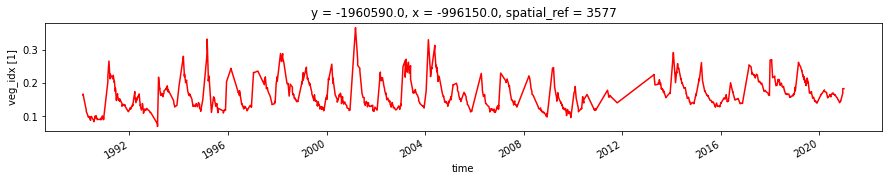

Subsetting data with buffers.
Subset years with buffers successfully.


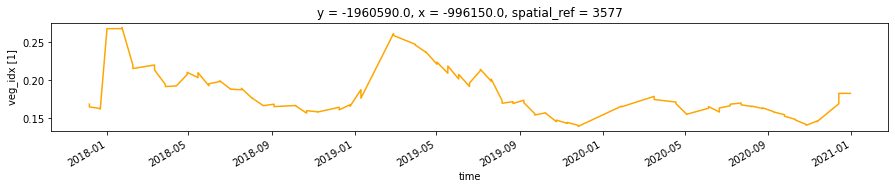

Resampling dataset.


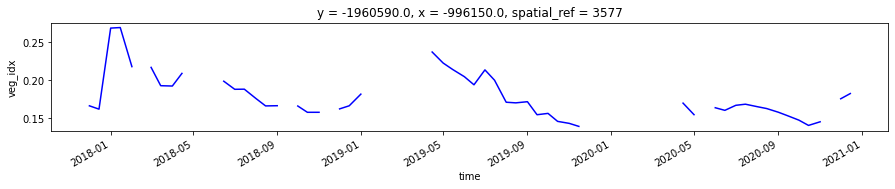

Interpolating empty values in dataset.
Interpolated empty values successfully.


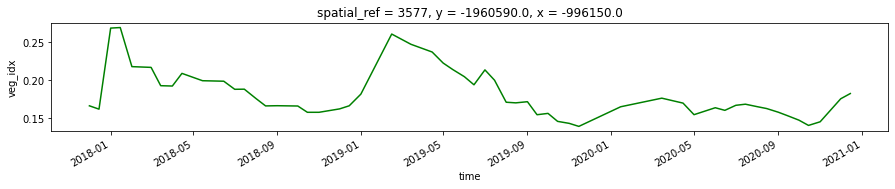

Removing spike outliers.
Outlier removal successful.


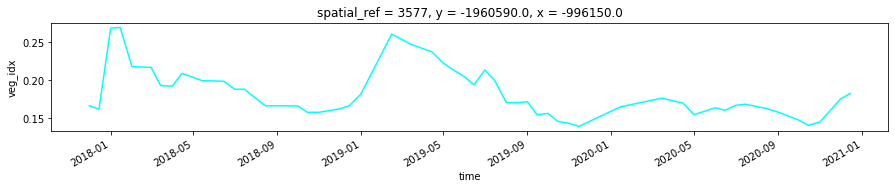

Interpolating empty values in dataset.
Interpolated empty values successfully.


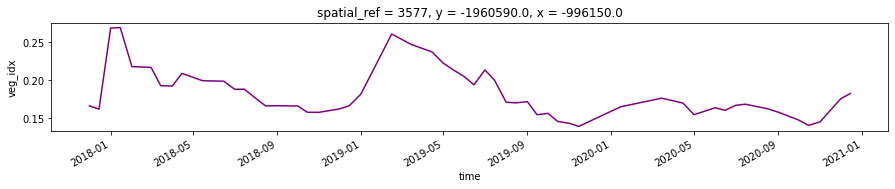

Smoothing data.
Smoothing successful.


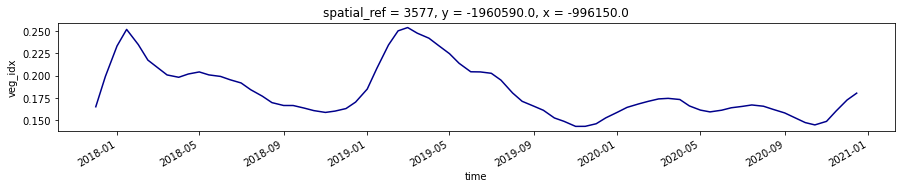

Subsetting data.
Subset years successfully.


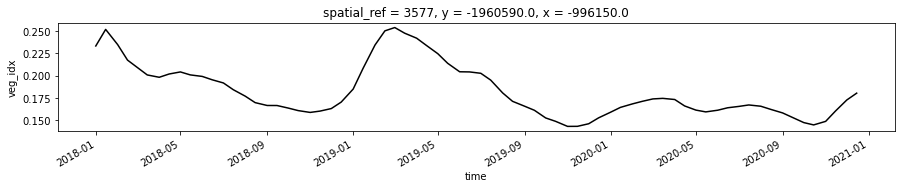

Grouping dataset.


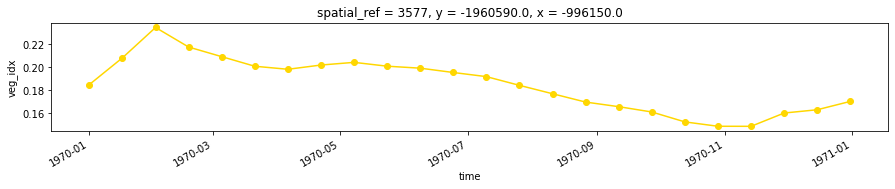

Resampling dataset.


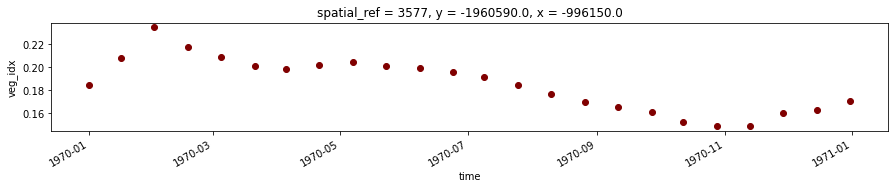

Interpolating empty values in dataset.
Interpolated empty values successfully.


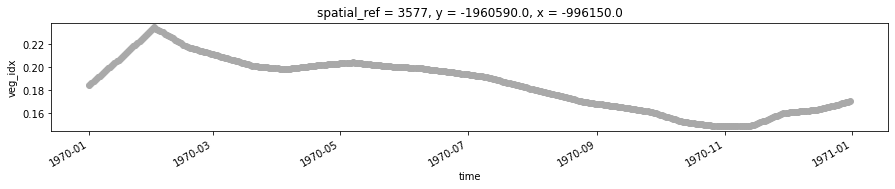

Removing overshoot date data.
Removed overshoot years successfully.


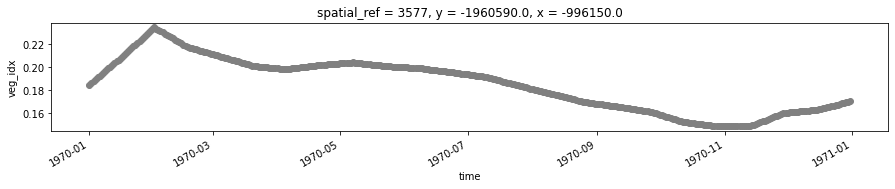

In [8]:
years = [2018, 2019, 2020]

i = 50
fix_edges = True

# load prepared ds
ds = xr.open_dataset(r"C:\Users\Lewis\Desktop\test\ls_tute.nc")
#ds = xr.open_dataset(r"C:\Users\Lewis\Desktop\test\s2_tute.nc")
ds = ds.chunk({'time': -1})
#ds = ds.load()
ds = ds.isel(x=slice(0, 150), y=slice(0, 150))

# check if current year selected
from datetime import datetime
if years is not None:
    if datetime.now().year in years:
        raise ValueError('Can not use current year.')
        
# check if 2011, 2012 ind ataset, error if so
if 2011 in years or 2012 in years:
    raise ValueError('Can not use years 2011 or 2012.')
        

# ensure edge dates exist for adequate interpolation
# if years is none, gets min, max years in ds
ds = phenolopy.enforce_edge_dates(ds=ds, years=years)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='red')
plt.show()


# subset with buffer dates either side, if years none, returns orig ds
ds = phenolopy.subset_via_years_with_buffers(ds=ds, years=years)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='orange')
plt.show()


# resample to fortnights
ds = phenolopy.resample(ds=ds, interval='SMS')
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='blue')
plt.show()


# interp any gaps from resample
ds = phenolopy.interpolate(ds=ds)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='green')
plt.show()


# set outliers to nan from fortnight
ds = phenolopy.remove_spikes(ds=ds, user_factor=2, win_size=3)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='aqua')
plt.show()


# interpolate once more to fill outlier gaps
ds = phenolopy.interpolate(ds=ds)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='purple')
plt.show()


# smooth the dataset
ds = phenolopy.smooth(ds=ds, var='veg_idx', window_length=3, polyorder=1)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='darkblue')
plt.show()


# do final subset to ensure only requested years in dataset
# if years is none, returns original ds
ds = phenolopy.subset_via_years(ds=ds, years=years)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='black')
plt.show()


# if len(ds['time']) not equal number (fortnight 12, 24, 48, etc)
# todo

# group years by m-d (1-1, 1-15, 2-1, 2-15, etc)
ds = phenolopy.group(ds=ds)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='gold', marker='o')
plt.show()


# do final resample up to to 365 days
ds = phenolopy.resample(ds=ds, interval='1D')
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='maroon', marker='o')
plt.show()


# interpolate our data one last time to fill those 365 days in
ds = phenolopy.interpolate(ds=ds)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='darkgrey', marker='o')
plt.show()


# do safety check to ensure no overshoot dates
ds = phenolopy.drop_overshoot_dates(ds=ds, min_dates=3)
fig = plt.figure(figsize=[15, 2])
ds['veg_idx'].isel(x=i, y=i).plot(color='grey', marker='o')
plt.show()


# if len(ds['time']) != 365: fail? or warn?
#

# run phenolopy

In [453]:
ds = ds.compute()

In [ ]:
#if peak is 365
# get next highest peak
# select next closest

In [10]:
out

<xarray.Dataset>
Dimensions:      (x: 150, y: 102)
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -1.959e+06 -1.959e+06 ... -1.962e+06 -1.962e+06
  * x            (x) float64 -9.976e+05 -9.976e+05 ... -9.932e+05 -9.932e+05
Data variables: (12/19)
    pos_values   (y, x) float32 0.3037 0.2844 0.2933 ... 0.3537 0.3489 0.3441
    pos_times    (y, x) float32 64.0 95.0 95.0 64.0 64.0 ... 80.0 64.0 64.0 64.0
    vos_values   (y, x) float32 0.1359 0.1342 0.1331 ... 0.1756 0.1781 0.1685
    vos_times    (y, x) float32 333.0 301.0 301.0 301.0 ... 301.0 301.0 301.0
    mos_values   (y, x) float32 0.2871 0.2671 0.2693 ... 0.3396 0.3334 0.3277
    bse_values   (y, x) float32 0.182 0.176 0.1737 ... 0.2269 0.2265 0.2164
    ...           ...
    rod_values   (y, x) float32 8.503 12.86 17.13 6.453 ... 9.645 10.16 10.71
    sios_values  (y, x) float32 13.27 12.62 13.08 12.63 ... 13.09 12.2 12.37
    lios_values  (y, x) float32 29.67 27.68 28.24 28.57 ... 30.89 28.82 27.68
    siot_values  (y, x) float32 26.0 25.25 26.04 26.24 ... 28.55 27.2 28.27
    liot_values  (y, x) float32 77.81 74.89 74.84 74.73 ... 96.69 95.21 92.6
    nos_values   (y, x) float32 1.0 3.0 1.0 3.0 3.0 1.0 ... 2.0 2.0 1.0 1.0 2.0

In [ ]:
        # var = 'pos_times'
        # ds[var] = xr.where((ds[var] > 0)   & (ds[var] <= 31),  1,  ds[var])
        # ds[var] = xr.where((ds[var] > 31)  & (ds[var] <= 59),  2,  ds[var])
        # ds[var] = xr.where((ds[var] > 59)  & (ds[var] <= 90),  3,  ds[var])
        # ds[var] = xr.where((ds[var] > 90)  & (ds[var] <= 120), 4,  ds[var])
        # ds[var] = xr.where((ds[var] > 120) & (ds[var] <= 151), 5,  ds[var])
        # ds[var] = xr.where((ds[var] > 151) & (ds[var] <= 181), 6,  ds[var])
        # ds[var] = xr.where((ds[var] > 181) & (ds[var] <= 212), 7,  ds[var])
        # ds[var] = xr.where((ds[var] > 212) & (ds[var] <= 243), 8,  ds[var])
        # ds[var] = xr.where((ds[var] > 243) & (ds[var] <= 273), 9,  ds[var])
        # ds[var] = xr.where((ds[var] > 273) & (ds[var] <= 304), 10, ds[var])
        # ds[var] = xr.where((ds[var] > 304) & (ds[var] <= 334), 11, ds[var])
        # ds[var] = xr.where((ds[var] > 334) & (ds[var] <= 365), 12, ds[var])
        
        # var = 'vos_times'
        # ds[var] = xr.where((ds[var] > 0)   & (ds[var] <= 31),  1,  ds[var])
        # ds[var] = xr.where((ds[var] > 31)  & (ds[var] <= 59),  2,  ds[var])
        # ds[var] = xr.where((ds[var] > 59)  & (ds[var] <= 90),  3,  ds[var])
        # ds[var] = xr.where((ds[var] > 90)  & (ds[var] <= 120), 4,  ds[var])
        # ds[var] = xr.where((ds[var] > 120) & (ds[var] <= 151), 5,  ds[var])
        # ds[var] = xr.where((ds[var] > 151) & (ds[var] <= 181), 6,  ds[var])
        # ds[var] = xr.where((ds[var] > 181) & (ds[var] <= 212), 7,  ds[var])
        # ds[var] = xr.where((ds[var] > 212) & (ds[var] <= 243), 8,  ds[var])
        # ds[var] = xr.where((ds[var] > 243) & (ds[var] <= 273), 9,  ds[var])
        # ds[var] = xr.where((ds[var] > 273) & (ds[var] <= 304), 10, ds[var])
        # ds[var] = xr.where((ds[var] > 304) & (ds[var] <= 334), 11, ds[var])
        # ds[var] = xr.where((ds[var] > 334) & (ds[var] <= 365), 12, ds[var])      

Preparing phenological metrics analysis...
Generating phenological metrics...
Generating pos, vos...
Generating mos, bse...
Generating aos...
Generating sos, eos...
Generating los...
Generating roi...
Generating rod...
Generating sios...
Generating lios...
Generating siot...
Generating liot...
Generating nos...
Generated phenological metrics successfully.
pos_values


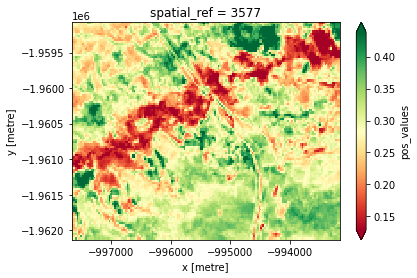

pos_times


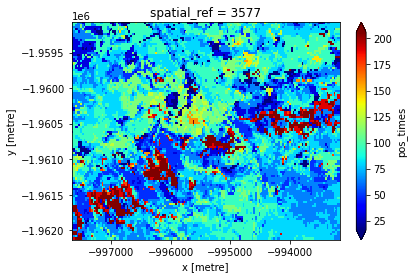

vos_values


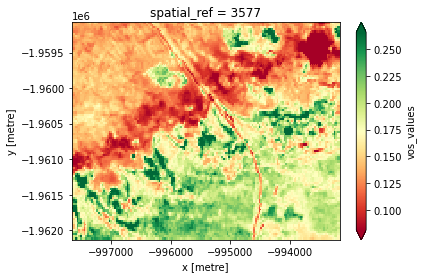

vos_times


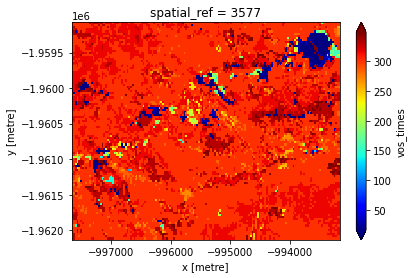

mos_values


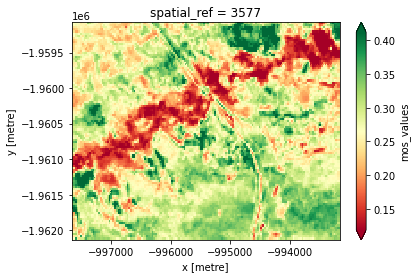

bse_values


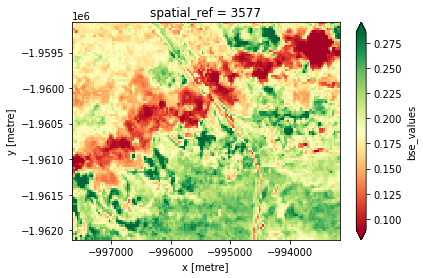

aos_values


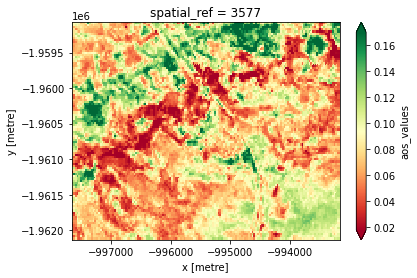

sos_values


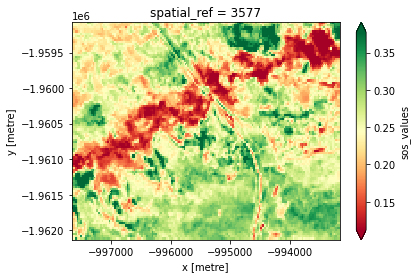

sos_times


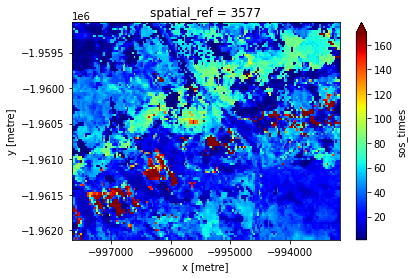

eos_values


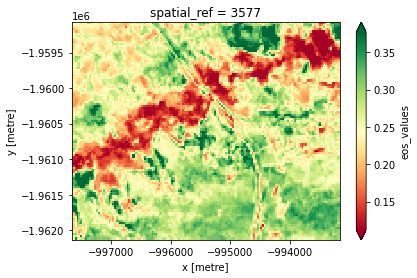

eos_times


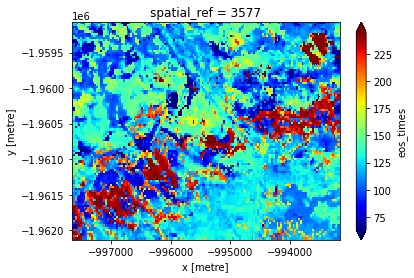

los_times


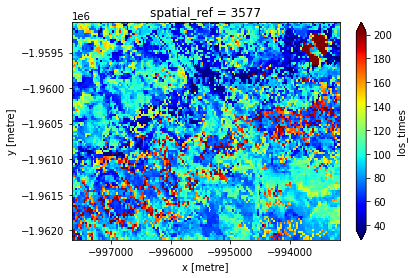

roi_values


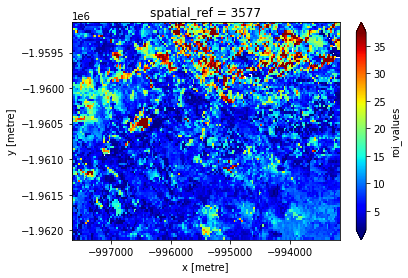

rod_values


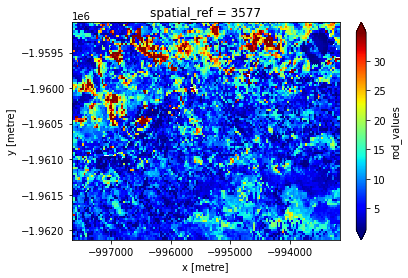

sios_values


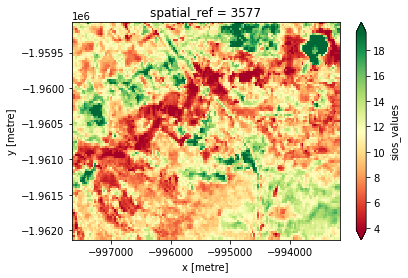

lios_values


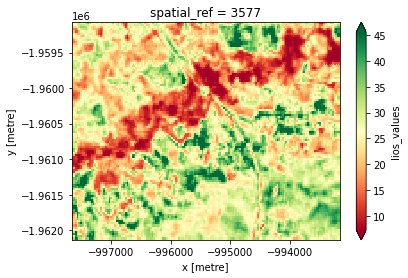

siot_values


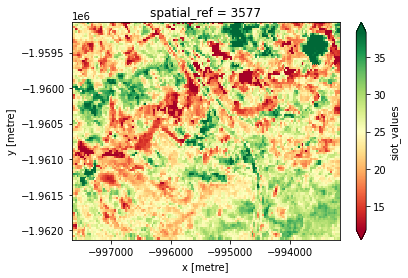

liot_values


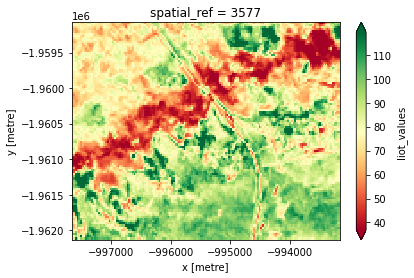

nos_values


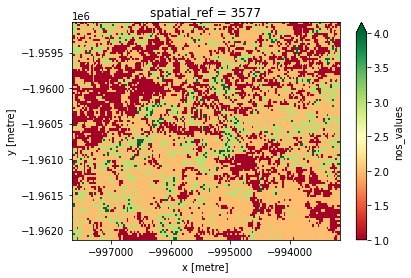

In [9]:
# calculate phenometrics!
out = phenolopy.get_phenometrics(ds=ds, 
                                 metrics=None, # all
                                 #method='relative_amplitude', 
                                 method='seasonal_amplitude',
                                 factor=0.75, 
                                 #abs_value=0,
                                 peak_spacing=12,
                                 fix_edges=True,
                                 fill_nan=True)

for var in out:        
    if '_t' in var or 'roi' in var or 'rod' in var:
        cmap = 'jet'
    elif 'sos_t' in var or 'eos_t' in var:
        cmap = 'gist_rainbow'
    elif '_v' in var:
        cmap = 'RdYlGn'

    print(var)
    out[var].plot(robust=True, cmap=cmap)
    plt.show()
    plt.close()

In [ ]:
raise

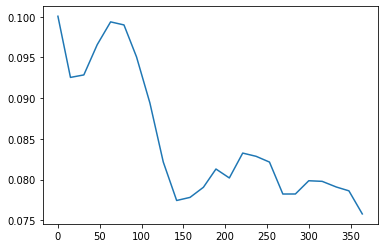

In [468]:
arr = ds['veg_idx'].isel(x=10, y=10).values
doy = ds['time.dayofyear']

plt.plot(arr)
plt.show()

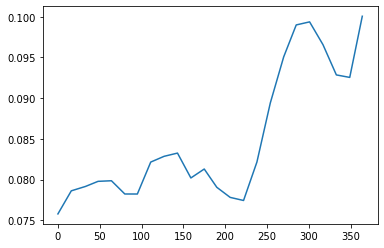

In [489]:
rra = np.flip(arr)
doy = ds['time.dayofyear']

plt.plot(rra)
plt.show()

In [496]:
idx

301

array([ 0,  1, 63, 64, 65], dtype=int64)

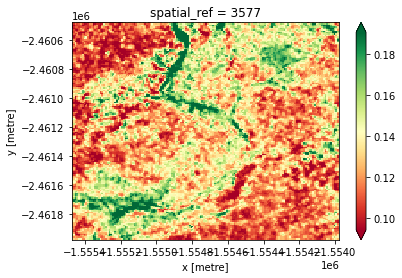

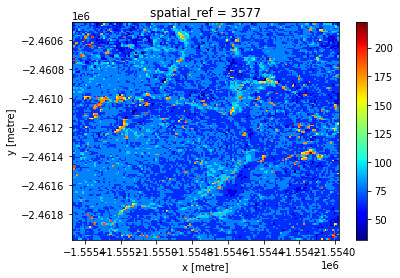

In [498]:
def _pos(arr, doy, fix_edges):

    # mask extreme edges
    if fix_edges:
        arr = phenolopy.clean_edges(arr, doy, 'max')
    
    #if doy[np.nanargmax(arr)] == 1:
        #max_idxs = (-arr).argsort()[:365]
        #idx = max_idxs[max_idxs > 31][0]
    #elif doy[np.nanargmax(arr)] == 1:
        #max_idxs = (-arr).argsort()[:365]
        #idx = max_idxs[max_idxs < 334][0]
    #else:
        #idx = np.nanargmax(arr)

    # get max value index
    idx = np.nanargmax(arr)

    # set values
    v, t = arr[idx], doy[idx]

    return v, t

# calculate peak of season (pos) values and times (doys)
da_pos_v, da_pos_t = xr.apply_ufunc(_pos,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'fix_edges': fix_edges})

da_pos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_pos_t.plot(cmap='jet')
plt.show()

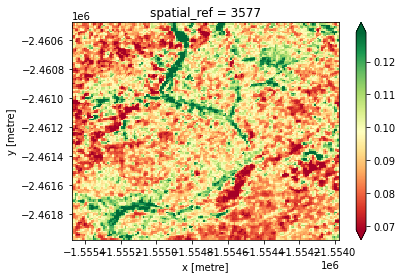

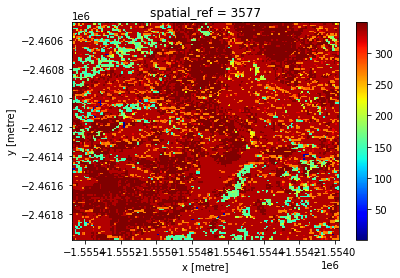

In [501]:
def _vos(arr, doy, fix_edges):
    
    # mask extreme edges
    if fix_edges:
        arr = phenolopy.clean_edges(arr, doy, 'min')

    # get min value index
    idx = np.nanargmin(arr)

    # set values
    v, t = arr[idx], doy[idx]

    return v, t  

# calculate valley of season (vos) values and times (doys)
da_vos_v, da_vos_t = xr.apply_ufunc(_vos,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'fix_edges': fix_edges})

da_vos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_vos_t.plot(cmap='jet')
plt.show()

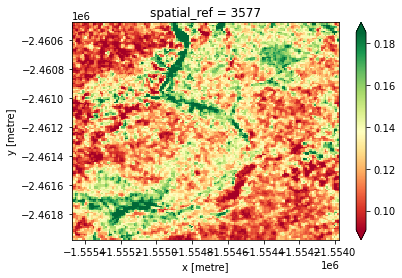

In [502]:
def _mos(arr, doy, fix_edges):
        
    # mask extreme edges
    if fix_edges:
        arr = phenolopy.clean_edges(arr, doy, 'max')
    
    # get pos time (doy)
    pos_t = doy[np.nanargmax(arr)]

    # get slope values left, right of pos time (doy)
    s_l, s_r = arr[doy <= pos_t], arr[doy >= pos_t]

    # get upper 80% values on left, right slopes
    s_l = s_l[s_l >= np.nanpercentile(s_l, 80)]
    s_r = s_r[s_r >= np.nanpercentile(s_r, 80)]

    # get mean of left, right slope
    s_l, s_r = np.nanmean(s_l), np.nanmean(s_r)

    # get mean of both
    v = np.nanmean([s_l, s_r])

    return v

# calculate middle of season (mos) values (no times)
da_mos_v = xr.apply_ufunc(_mos,
                          ds['veg_idx'],
                          ds['time.dayofyear'],
                          input_core_dims=[['time'], ['time']],
                          output_core_dims=[[]],
                          vectorize=True,
                          dask='allowed',
                          output_dtypes=['float32'],
                          kwargs={'fix_edges': fix_edges})

da_mos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

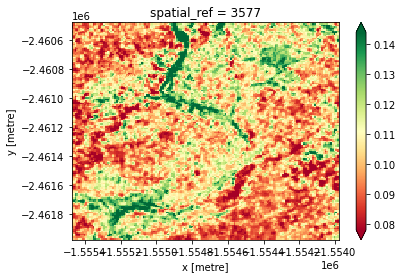

In [503]:
def _bse(arr, doy, fix_edges):
    
    # mask extreme edges
    if fix_edges:
        arr = phenolopy.clean_edges(arr, doy, 'min')
    
    # get pos time (doy)
    pos_t = doy[np.nanargmax(arr)]

    # get slope values left, right of pos time (doy)
    s_l, s_r = arr[doy <= pos_t], arr[doy >= pos_t]
    
    # get min value on left, right of slope
    s_l, s_r = np.nanmin(s_l), np.nanmin(s_r)

    # get mean of both
    v = np.nanmean([s_l, s_r])

    return v

# calculate base (bse) values (no times)
da_bse_v = xr.apply_ufunc(_bse,
                          ds['veg_idx'],
                          ds['time.dayofyear'],
                          input_core_dims=[['time'], ['time']],
                          output_core_dims=[[]],
                          vectorize=True,
                          dask='allowed',
                          output_dtypes=['float32'],
                          kwargs={'fix_edges': fix_edges})

da_bse_v.plot(cmap='RdYlGn', robust=True)
plt.show()

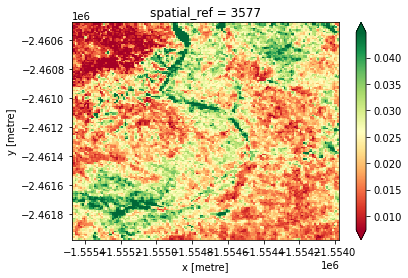

In [504]:
def _aos(arr_upper, arr_lower):
    
    # get aos values
    v = np.abs(arr_upper - arr_lower)

    return v

# calculate amplitude of season (aos) values (no times)
da_aos_v = xr.apply_ufunc(_aos,
                          da_mos_v,
                          da_bse_v,
                          dask='allowed',
                          output_dtypes=['float32'])

da_aos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

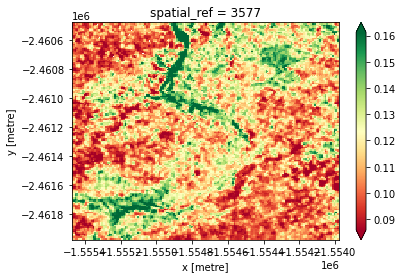

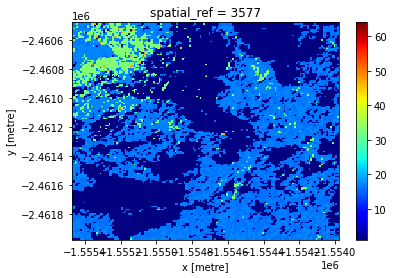

In [506]:
def _sos_fos(arr, doy, fix_edges):
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()
        
        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')       
        
        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values left of pos and where slope +
        diff = np.where(np.gradient(arr) > 0, True, False)
        s_l = np.where((doy <= pos_t) & diff, arr, np.nan)

        # build non-nan start and end index ranges for slope +
        clusts = np.ma.clump_unmasked(np.ma.masked_invalid(s_l))

        # if cluster(s) exist, get last element of slope, else last element
        idx = 0
        if len(clusts) != 0:
            idx = clusts[0].start

        # set values
        v, t = arr[idx], doy[idx]
    
    except:
        v, t = arr_tmp[0], doy[0]

    return v, t  

# calculate start of season (sos) values and times (doys)
da_sos_v, da_sos_t = xr.apply_ufunc(_sos_fos,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'fix_edges': fix_edges})

da_sos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_sos_t.plot(cmap='jet')
plt.show()

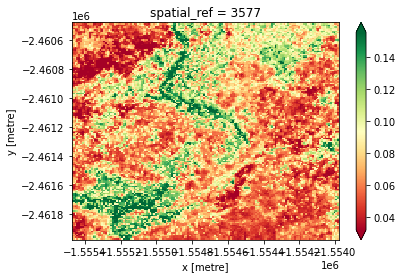

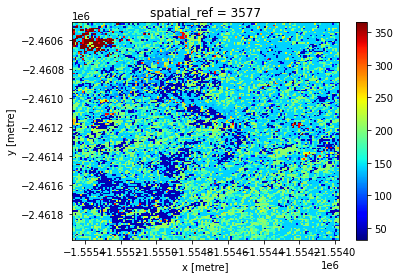

In [360]:
def _eos_fos(arr, doy, fix_edges):
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()
        
        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')
        
        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values right of pos and where slope -
        diff = np.where(np.gradient(arr) < 0, True, False)
        s_r = np.where((doy >= pos_t) & diff, arr, np.nan)

        # build non-nan start and end index ranges for slope -
        clusts = np.ma.clump_unmasked(np.ma.masked_invalid(s_r))

        # if cluster(s) exist, get last of slope
        idx = -1
        if len(clusts) != 0:
            idx = clusts[0].stop - 1
        
        # set values
        v, t = arr[idx], doy[idx]
    
    except:
        v, t = arr_tmp[-1], doy[-1]

    return v, t   

# calculate end of season (eos) values and times (doys)
da_eos_v, da_eos_t = xr.apply_ufunc(_eos_fos,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'fix_edges': fix_edges})

da_eos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_eos_t.plot(cmap='jet')
plt.show()

D66140B0-0277-45FF-AE18-A787BE3D4AAF:19: RuntimeWarning: Mean of empty slice


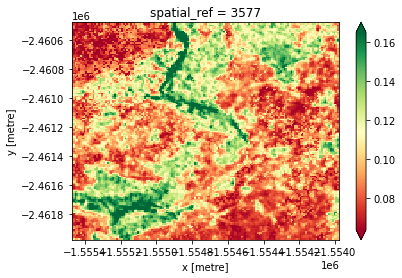

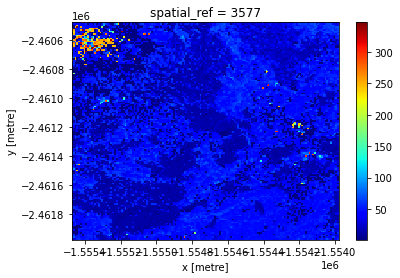

In [361]:
def _sos_mos(arr, doy, fix_edges):
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()
        
        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')
        
        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values left of pos and where slope +
        diff = np.where(np.gradient(arr) > 0, True, False)
        
        s_l = np.where((doy <= pos_t) & diff, arr, np.nan)
        
        # get mean of all values in slope + areas
        mean = np.nanmean(s_l)
        
        # calc abs distances of each slope + val and mean
        dists = np.abs(s_l - mean)
        
        # get the smallest idx
        idx = np.nanargmin(dists)
        
        # set values
        v = arr[idx]
        t = doy[idx]
    
    except:
        v, t = arr_tmp[0], doy[0]

    return v, t  

# calculate start of season (sos) values and times (doys)
da_sos_v, da_sos_t = xr.apply_ufunc(_sos_mos,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'fix_edges': fix_edges})

da_sos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_sos_t.plot(cmap='jet')
plt.show()

D66140B0-0277-45FF-AE18-A787BE3D4AAF:18: RuntimeWarning: Mean of empty slice


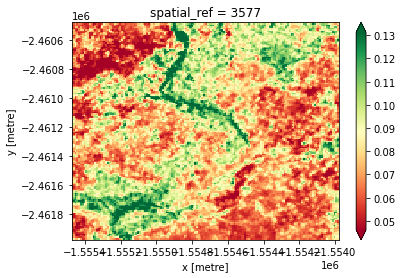

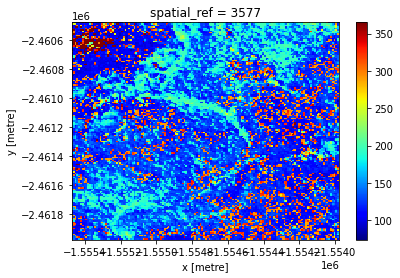

In [362]:
def _eos_mos(arr, doy, fix_edges):
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()
        
        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')

        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values right of pos and where slope -
        diff = np.where(np.gradient(arr) < 0, True, False)
        s_r = np.where((doy >= pos_t) & diff, arr, np.nan)
        
        # get mean of all values in slope - areas
        mean = np.nanmean(s_r)
        
        # calc abs distances of each slope - val and mean
        dists = np.abs(s_r - mean)
        
        # get the smallest idx
        idx = np.nanargmin(dists)
        
        # set values
        v = arr[idx]
        t = doy[idx]

    except:
        v, t = arr_tmp[-1], doy[-1]
        
    return v, t

# calculate end of season (eos) values and times (doys)
da_eos_v, da_eos_t = xr.apply_ufunc(_eos_mos,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'fix_edges': fix_edges})

da_eos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_eos_t.plot(cmap='jet')
plt.show()

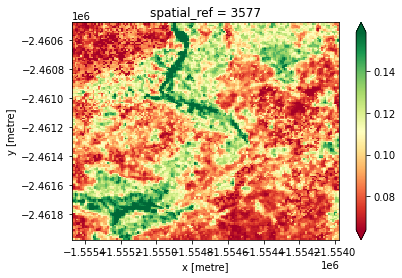

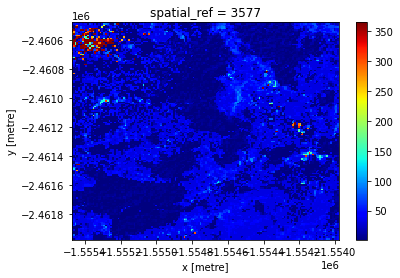

In [368]:
def _sos_seaamp(arr, doy, arr_aos_v, arr_bse_v, factor, fix_edges):   
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()
        
        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')

        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values left of pos and where slope +
        diff = np.where(np.gradient(arr) > 0, True, False)       
        s_l = np.where((doy <= pos_t) & diff, arr, np.nan)

        # add base to amplitude and threshold it via factor
        samp = float((arr_aos_v * factor) + arr_bse_v)

        # calc abs distances of each slope + val to seas amp
        dists = np.abs(s_l - samp)

        # get the smallest idx
        idx = np.nanargmin(dists)

        # set values
        v, t = arr[idx], doy[idx]
        
    except:
        v, t = arr_tmp[0], doy[0]

    return v, t  

# calculate start of season (sos) values and times (doys)
da_sos_v, da_sos_t = xr.apply_ufunc(_sos_seaamp,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    da_aos_v,
                                    da_bse_v,
                                    input_core_dims=[['time'], ['time'], [], []],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'factor': 0.75, 'fix_edges': fix_edges})

da_sos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_sos_t.plot(cmap='jet')
plt.show()

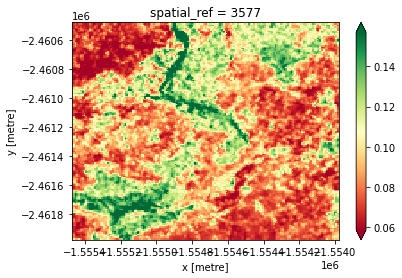

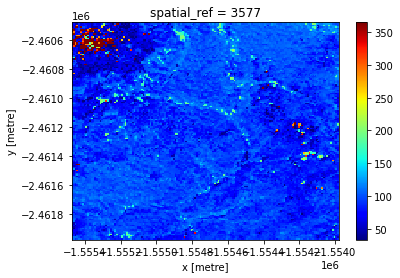

In [369]:
def _eos_seaamp(arr, doy, arr_aos_v, arr_bse_v, factor, fix_edges):
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()
        
        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')

        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values right of pos and where slope -
        diff = np.where(np.gradient(arr) < 0, True, False)       
        s_r = np.where((doy >= pos_t) & diff, arr, np.nan)

        # add base to amplitude and threshold it via factor
        samp = float((arr_aos_v * factor) + arr_bse_v)

        # calc abs distances of each slope - val to seas amp
        dists = np.abs(s_r - samp)

        # get the smallest idx
        idx = np.nanargmin(dists)

        # set values
        v, t = arr[idx], doy[idx]
        
    except:
        v, t = arr_tmp[-1], doy[-1]

    return v, t  

# calculate end of season (sos) values and times (doys)
da_eos_v, da_eos_t = xr.apply_ufunc(_eos_seaamp,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    da_aos_v,
                                    da_bse_v,
                                    input_core_dims=[['time'], ['time'], [], []],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'factor': 0.75, 'fix_edges': fix_edges})

da_eos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_eos_t.plot(cmap='jet')
plt.show()

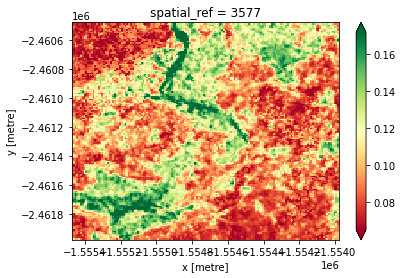

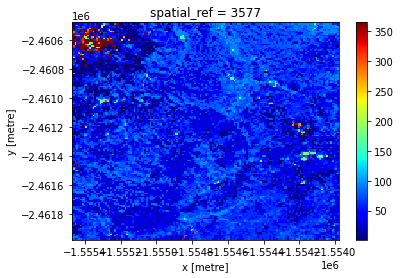

In [372]:
def _sos_absamp(arr, doy, abs_value, fix_edges):
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()
        
        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')

        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values left of pos and where slope +
        diff = np.where(np.gradient(arr) > 0, True, False)       
        s_l = np.where((doy <= pos_t) & diff, arr, np.nan)

        # calc abs distances of each slope + val to absolute val
        dists = np.abs(s_l - abs_value)

        # get the smallest idx
        idx = np.nanargmin(dists)

        # set values
        v, t = arr[idx], doy[idx]
        
    except:
        v, t = arr_tmp[0], doy[0]

    return v, t  

# calculate start of season (sos) values and times (doys)
da_sos_v, da_sos_t = xr.apply_ufunc(_sos_absamp,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'abs_value': 0.3, 'fix_edges': fix_edges})

da_sos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_sos_t.plot(cmap='jet')
plt.show()

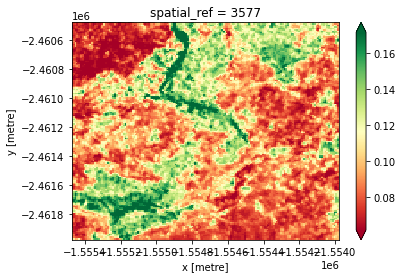

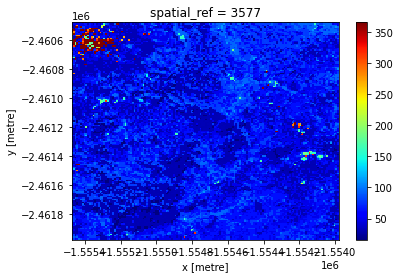

In [373]:
def _eos_absamp(arr, doy, abs_value, fix_edges):
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()
        
        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')

        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values right of pos and where slope -
        diff = np.where(np.gradient(arr) < 0, True, False)       
        s_r = np.where((doy >= pos_t) & diff, arr, np.nan)

        # calc abs distances of each slope - val to absolute val
        dists = np.abs(s_r - abs_value)

        # get the smallest idx
        idx = np.nanargmin(dists)

        # set values
        v, t = arr[idx], doy[idx]
        
    except:
        v, t = arr_tmp[-1], doy[-1]

    return v, t  

# calculate end of season (sos) values and times (doys)
da_eos_v, da_eos_t = xr.apply_ufunc(_eos_absamp,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'abs_value': 0.3, 'fix_edges': fix_edges})

da_eos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_eos_t.plot(cmap='jet')
plt.show()

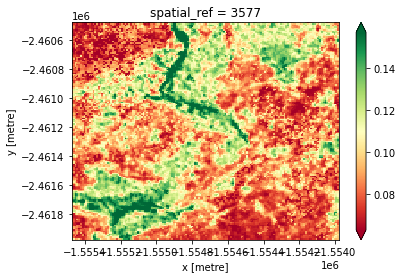

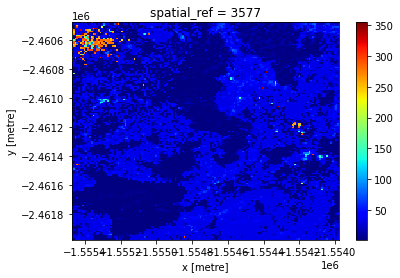

In [374]:
def _sos_relamp(arr, doy, factor, fix_edges):
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()

        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')

        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values left of pos and where slope +
        diff = np.where(np.gradient(arr) > 0, True, False)       
        s_l = np.where((doy <= pos_t) & diff, arr, np.nan)

        # get relative amp via robust max and base (10% cut off)
        q_min = np.nanpercentile(arr, q=10)
        q_max = np.nanpercentile(arr, q=90)
        ramp = float(q_max - q_min)

        # add max to relative amp and threshold it via factor
        ramp = (ramp * factor) + q_min
               
        # calc abs distances of each slope + val to relative value
        dists = np.abs(s_l - ramp)

        # get the smallest idx
        idx = np.nanargmin(dists)

        # set values
        v, t = arr[idx], doy[idx]

    except:
        v, t = arr_tmp[0], doy[0]

    return v, t  

# calculate start of season (sos) values and times (doys)
da_sos_v, da_sos_t = xr.apply_ufunc(_sos_relamp,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'factor': 0.75, 'fix_edges': fix_edges})

da_sos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_sos_t.plot(cmap='jet')
plt.show()

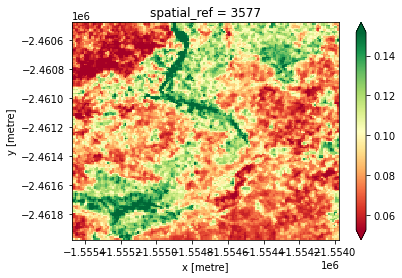

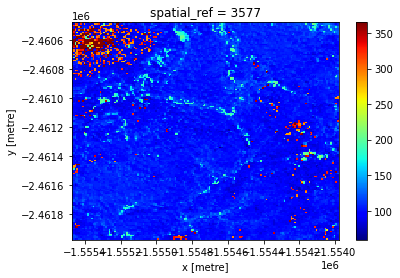

In [376]:
def _eos_relamp(arr, doy, factor, fix_edges):
    try:
        # make copy of arr for error handling
        arr_tmp = arr.copy()
        
        # mask extreme edges
        if fix_edges:
            arr = phenolopy.clean_edges(arr, doy, 'max')

        # get pos time (doy)
        pos_t = doy[np.nanargmax(arr)]

        # get all values right of pos and where slope +
        diff = np.where(np.gradient(arr) < 0, True, False)       
        s_r = np.where((doy >= pos_t) & diff, arr, np.nan)

        # get relative amp via robust max and base (10% cut off)
        q_min = np.nanpercentile(arr, q=10)
        q_max = np.nanpercentile(arr, q=90)
        ramp = float(q_max - q_min)

        # add max to relative amp and threshold it via factor
        ramp = (ramp * factor) + q_min

        # calc abs distances of each slope + val to relative value
        dists = np.abs(s_r - ramp)

        # get the smallest idx
        idx = np.nanargmin(dists)

        # set values
        v, t = arr[idx], doy[idx]
        
    except:
        v, t = arr_tmp[-1], doy[-1]

    return v, t  

# calculate end of season (eos) values and times (doys)
da_eos_v, da_eos_t = xr.apply_ufunc(_eos_relamp,
                                    ds['veg_idx'],
                                    ds['time.dayofyear'],
                                    input_core_dims=[['time'], ['time']],
                                    output_core_dims=[[], []],
                                    vectorize=True,
                                    dask='allowed',
                                    output_dtypes=['float32', 'float32'],
                                    kwargs={'factor': 0.75, 'fix_edges': fix_edges})

da_eos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

da_eos_t.plot(cmap='jet')
plt.show()

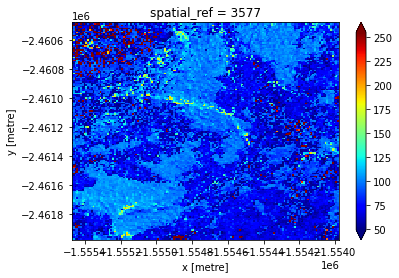

In [377]:
def _los(arr_sos_t, arr_eos_t):

    # get los values
    v = np.abs(arr_eos_t - arr_sos_t)    

    return v

# calculate amplitude of season (aos) values (no times)
da_los_v = xr.apply_ufunc(_los,
                          da_sos_t,
                          da_eos_t,
                          vectorize=True,
                          dask='allowed',
                          output_dtypes=['float32'])

try:
    # interpolate nan values
    mask = xr.where(da_los_v.isnull(), True, False)
    da_roi_v = xr.apply_ufunc(phenolopy.interpolate_2d,
                              da_los_v,
                              mask,
                              dask='allowed',
                              output_dtypes=['float32'],
                              kwargs={'method': 'nearest'})
except:
    pass

da_los_v.plot(cmap='jet', robust=True)
plt.show()

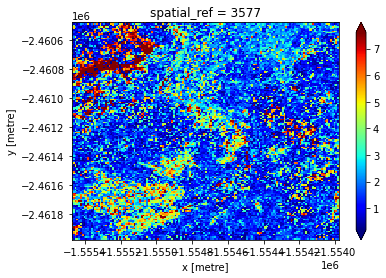

In [419]:
def _roi(arr_pos_v, arr_pos_t, arr_sos_v, arr_sos_t):
    try:
        # get roi values   
        v = ((arr_pos_v - arr_sos_v) / 
             (arr_pos_t - arr_sos_t) * 10000)

        # get absolute if negatives
        v = np.abs(v)
    
    except:
        v = np.nan
    
    return v

# calculate rate of increase values (no times)
da_roi_v = xr.apply_ufunc(_roi,
                          da_pos_v,
                          da_pos_t,
                          da_sos_v,
                          da_sos_t,
                          #vectorize=True,
                          dask='allowed',
                          output_dtypes=['float32'])

try:
    # interpolate nan values
    mask = xr.where(da_roi_v.isnull(), True, False)
    da_roi_v = xr.apply_ufunc(phenolopy.interpolate_2d,
                              da_roi_v,
                              mask,
                              dask='allowed',
                              output_dtypes=['float32'],
                              kwargs={'method': 'nearest'})
except:
    pass

da_roi_v.plot(cmap='jet', robust=True)
plt.show()

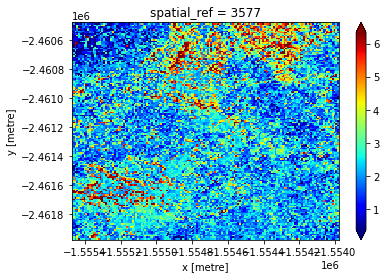

In [420]:
def _rod(arr_pos_v, arr_pos_t, arr_eos_v, arr_eos_t):
    try:
        # get rod values   
        v = ((arr_eos_v - arr_pos_v) / 
             (arr_eos_t - arr_pos_t) * 10000)
        
        # get absolute if negatives
        v = np.abs(v)
        
    except:
        v = np.nan
    
    return v

# calculate rate of increase values (no times)
da_rod_v = xr.apply_ufunc(_rod,
                          da_pos_v,
                          da_pos_t,
                          da_eos_v,
                          da_eos_t,
                          input_core_dims=[[], [], [], []],
                          output_core_dims=[[]],
                          vectorize=True,
                          dask='allowed',
                          output_dtypes=['float32'])

try:
    # interpolate nan values
    mask = xr.where(da_rod_v.isnull(), True, False)
    da_rod_v = xr.apply_ufunc(phenolopy.interpolate_2d,
                              da_rod_v,
                              mask,
                              dask='allowed',
                              output_dtypes=['float32'],
                              kwargs={'method': 'nearest'})
except:
    pass

da_rod_v.plot(cmap='jet', robust=True)
plt.show()

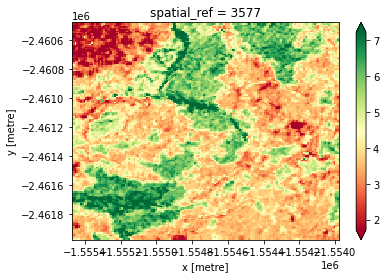

In [407]:
def _sios(arr, doy, arr_sos_t, arr_eos_t, arr_bse_v):
    try:        
        # subtract the base from the original array
        arr = arr - arr_bse_v 
        
        # get all idxs between start and end of season
        season_idxs = np.where((doy >= arr_sos_t) & 
                               (doy <= arr_eos_t))

        # subset arr and doy whereever in range
        arr = arr[season_idxs]
        doy = doy[season_idxs]
        
        # get short integral of all values via trapz   
        v = np.trapz(y=arr, x=doy)
        
        # rescale if negatives
        #if np.min(v) < 0:
            #v += np.abs(np.nanmin(v))
    
    except:
        v = np.nan
    
    return v

# calculate short integral of season (no times)
da_sios_v = xr.apply_ufunc(_sios,
                           ds['veg_idx'],
                           ds['time.dayofyear'],
                           #da_sos_t,
                           #da_eos_t,
                           da_sos_t.rolling(x=3, y=3, center=True, min_periods=1).mean(),
                           da_eos_t.rolling(x=3, y=3, center=True, min_periods=1).mean(),
                           da_bse_v,
                           input_core_dims=[['time'], ['time'], [], [], []],
                           output_core_dims=[[]],
                           vectorize=True,
                           dask='allowed',
                           output_dtypes=['float32'])

if da_sios_v.min() < 0:
    da_sios_v = da_sios_v + np.abs(da_sios_v.min())

da_sios_v.plot(cmap='RdYlGn', robust=True)
plt.show()

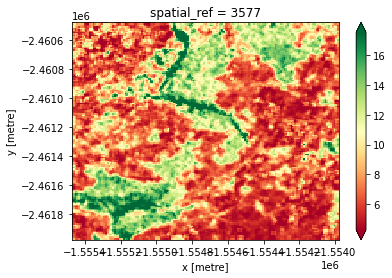

In [401]:
def _lios(arr, doy, arr_sos_t, arr_eos_t):
    try:        
        # get all idxs between start and end of season
        season_idxs = np.where((doy >= arr_sos_t) &
                               (doy <= arr_eos_t))

        # subset arr and doy whereever in range
        arr = arr[season_idxs]
        doy = doy[season_idxs]
        
        # get long integral of all values via trapz   
        v = np.trapz(y=arr, x=doy)
        
        # rescale if negatives
        #if np.min(v) < 0:
            #v += np.abs(np.nanmin(v))
    
    except:
        v = np.nan
    
    return v

# calculate long integral of season (no times)
da_lios_v = xr.apply_ufunc(_lios,
                           ds['veg_idx'],
                           ds['time.dayofyear'],
                           #da_sos_t,
                           #da_eos_t,
                           da_sos_t.rolling(x=3, y=3, center=True, min_periods=1).mean(),
                           da_eos_t.rolling(x=3, y=3, center=True, min_periods=1).mean(),
                           input_core_dims=[['time'], ['time'], [], []],
                           output_core_dims=[[]],
                           vectorize=True,
                           dask='allowed',
                           output_dtypes=['float32'])

try:
    # interpolate nan values
    mask = xr.where(da_lios_v.isnull(), True, False)
    da_lios_v = xr.apply_ufunc(phenolopy.interpolate_2d,
                               da_lios_v,
                               mask,
                               dask='allowed',
                               output_dtypes=['float32'],
                               kwargs={'method': 'nearest'})
except:
    pass

if da_lios_v.min() < 0:
    da_lios_v = da_lios_v + np.abs(da_lios_v.min())

da_lios_v.plot(cmap='RdYlGn', robust=True)
plt.show()

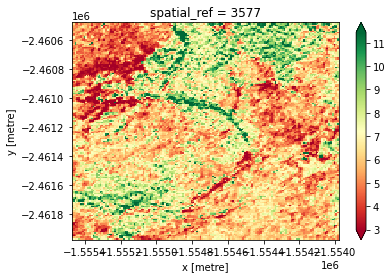

In [421]:
def _siot(arr, doy, arr_bse_v):
    try:        
        # subtract the base from the orig array
        arr = arr - arr_bse_v
                
        # get long integral of all values via trapz first
        v = np.trapz(y=arr, x=doy) 
        
        # rescale if negatives
        #if np.min(v) < 0:
            #v += np.abs(np.nanmin(v))

    except:
        v = np.nan
    
    return v

# calculate short integral of total (no times)
da_siot_v = xr.apply_ufunc(_siot,
                           ds['veg_idx'],
                           ds['time.dayofyear'],
                           da_bse_v,
                           input_core_dims=[['time'], ['time'], []],
                           output_core_dims=[[]],
                           vectorize=True,
                           dask='allowed',
                           output_dtypes=['float32'])


try:
    # interpolate nan values
    mask = xr.where(da_siot_v.isnull(), True, False)
    da_siot_v = xr.apply_ufunc(phenolopy.interpolate_2d,
                               da_siot_v,
                               mask,
                               dask='allowed',
                               output_dtypes=['float32'],
                               kwargs={'method': 'nearest'})
except:
    pass


if da_siot_v.min() < 0:
    da_siot_v = da_siot_v + abs(da_siot_v.min())

da_siot_v.plot(cmap='RdYlGn', robust=True)
plt.show()

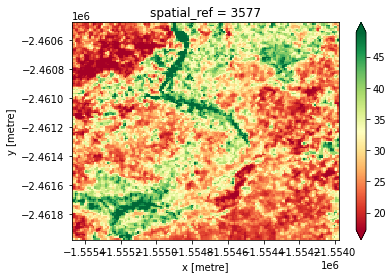

In [408]:
def _liot(arr, doy):
    try:
        # get long integral of all values via trapz   
        v = np.trapz(y=arr, x=doy)
        
        # rescale if negatives
        #if np.min(v) < 0:
            #v += np.abs(np.nanmin(v))
    
    except:
        v = np.nan
    
    return v

# calculate long integral of total (no times)
da_liot_v = xr.apply_ufunc(_liot,
                           ds['veg_idx'],
                           ds['time.dayofyear'],
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[[]],
                           vectorize=True,
                           dask='allowed',
                           output_dtypes=['float32'])


try:
    # interpolate nan values
    mask = xr.where(da_liot_v.isnull(), True, False)
    da_liot_v = xr.apply_ufunc(phenolopy.interpolate_2d,
                              da_liot_v,
                              mask,
                              dask='allowed',
                              output_dtypes=['float32'],
                              kwargs={'method': 'nearest'})
except:
    pass

if da_liot_v.min() < 0:
    da_liot_v = da_liot_v + np.abs(da_liot_v.min())

da_liot_v.plot(cmap='RdYlGn', robust=True)
plt.show()

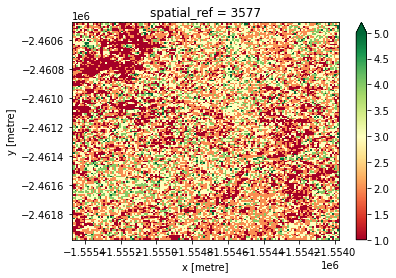

In [410]:
from scipy.signal import find_peaks
def _nos(arr, doy, peak_spacing):
    try:
        # calculate peak prominence, divide by months
        t = ((np.nanmax(arr) - np.nanmin(arr)) / 
             (len(doy) / peak_spacing))

        # generate peak information
        peaks, _ = find_peaks(arr, prominence=t)

        # set value to 1 season, else > 1
        v = len(peaks) if len(peaks) > 0 else 1

    except:
        v = np.nan
    
    return v

# calculate number of seasons (nos) (no times)
da_nos_v = xr.apply_ufunc(_nos,
                          ds['veg_idx'],
                          ds['time.dayofyear'],
                          input_core_dims=[['time'], ['time']],
                          output_core_dims=[[]],
                          vectorize=True,
                          dask='allowed',
                          output_dtypes=['float32'],
                          kwargs={'peak_spacing': 12})

try:
    # interpolate nan values
    mask = xr.where(da_nos_v.isnull(), True, False)
    da_nos_v = xr.apply_ufunc(phenolopy.interpolate_2d,
                              da_nos_v,
                              mask,
                              dask='allowed',
                              output_dtypes=['float32'],
                              kwargs={'method': 'nearest'})
except:
    pass

da_nos_v.plot(cmap='RdYlGn', robust=True)
plt.show()

In [385]:
raise

RuntimeError: No active exception to reraise

In [ ]:
if doy[np.nanargmax(arr)] == 1:
    max_idxs = (-arr).argsort()[:365]
    idx = max_idxs[max_idxs > 31][0]
elif doy[np.nanargmax(arr)] == 1:
    max_idxs = (-arr).argsort()[:365]
    idx = max_idxs[max_idxs < 334][0]
else:
    idx = np.nanargmax(arr)


In [ ]:
# get all intersections with curve vs thresh line
tmp = np.full_like(arr, ramp)        
idxs = np.argwhere(np.diff(np.sign(tmp - arr))).flatten()
idxs = np.intersect1d(idxs, np.where(diff))
idx = idxs[0]

In [ ]:
def _x(arr, spike_factor):
        
    # get std cutoff
    cutoff = np.std(arr, axis=2) * spike_factor
    
    # get median
    win = sliding_window_view(arr, window_shape=3, axis=2)
    arr_med = np.nanmedian(win, axis=2)

    # prepend, append nan
    arr_med = np.insert(arr_med, 0, np.nan, axis=2)
    arr_med = np.append(arr_med, np.nan, axis=2)

    # calc abs difference between orig and med 
    #arr_dif = np.abs(arr - arr_med)

    # calc mask
    #arr_mask = arr_dif > cutoff

    # set to nan if rules broken at each masked value
    #for i in np.where(arr_mask)[0]:
        #v, l, r = arr[i], arr[i - 1], arr[i + 1]
        #_mean, _max = np.nanmean([l, r]), np.nanmax([l, r])

        #if v < (_mean - cutoff) or v > _max + cutoff:
            #arr[i] = np.nan

    return arr

No Python documentation found for 'RasterStretchColorizer'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

